In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import simps,cumtrapz
from scipy.interpolate import interp1d

# Helper functions
class ProcessPAFI:
    def __init__(self, csv_file, validity_fn = lambda x : x['MaxJump']<0.4) :
        """
            Take a PAFI csv data dump and produce ensemble average and standard deviation
            `data` : pandas DataFrame in PAFI format
            `validity_criteria` : a function acting on a Dataframe which returns valid data
        """
        self.all_data = pd.read_csv(csv_file)
        self.nWorkers = max(set(self.all_data['WorkerID'])) + 1
        self.validity_fn = validity_fn
        self.validate()
        self.ensemble_average()
    
    def validate(self):
        self.valid = np.ones(self.all_data.shape[0],bool)
        self.nValid = self.valid.sum()
        if not self.validity_fn is None:
             self.valid = self.validity_fn(self.all_data)
        
    def ensemble_average(self):
        
        data = self.all_data[self.valid]


        # Every field before nWorkers is a parameter
        self.nParams = np.where(data.columns=='WorkerID')[0][0]
        self.param_names = list(data.columns[:self.nParams])
        self.field_names = list(data.columns[self.nParams+1:])
        
        raw_data = data.drop('WorkerID', 1).to_numpy()
        # parameters
        self.param_data = pd.DataFrame(data = raw_data[:,:self.nParams],
                                       columns = self.param_names).drop_duplicates()
        # ensemble
        ens_columns = self.param_names + self.field_names + [f+"_std" for f in self.field_names]
        ens_data = []        
        for p in self.param_data.to_numpy():
            sel = (raw_data[:,:self.nParams] == p).min(axis=1)
            ens_data += [list(raw_data[sel].mean(axis=0)) + list(raw_data[sel].std(axis=0)[self.nParams:])]
        self.ens_data = pd.DataFrame(data = np.r_[ens_data], columns = ens_columns)
    
    # splined rediscretization, first column is coordinate
    def remesh(self,data,density = 10):
        spl_data = np.zeros((density*data.shape[0],data.shape[1]))
        spl_data[:,0] = np.linspace(data[:,0][0],data[:,0][-1],spl_data.shape[0])
        for ii in range(1,data.shape[1]):
            spl_data[:,ii] = interp1d(data[:,0], data[:,ii],kind='linear')(spl_data[:,0])
        return spl_data


    def integrate(self,x='ReactionCoordinate',y='aveF',remesh=1):
        """
            Integrate ensemble average free energy gradient with respect to r, with error
            `ens` : ensemble average dataset
        """
        if not x in self.ens_data.columns[:self.nParams]:
            print("PAFI data has no parameter named \"%s\"" % x)
            return
        
        if not y in self.ens_data.columns[self.nParams:]:
            print("PAFI data has field named \"%s\"" % y)
            return
        
        # get number of values for which we produces curves
        param_data = self.param_data.drop(x,1).drop_duplicates()
        
        self.integrated_data = []
        
        for p in param_data.iterrows():
            ee = self.ens_data.copy()
            for key,val in p[1].iteritems():
                ee = ee[ee[key]==val]
            
            print()
            data = np.r_[[ee[w].to_numpy() for w in [x,y,y+"_std"]]].T
            
            data = self.remesh(data[data[:,0].argsort(),:],remesh)
            integrated_data = p[1].to_dict()
            integrated_data[x] = data[:,0]
            integrated_data[y+"_int"] = np.append(np.zeros(1),cumtrapz(data[:,1],data[:,0]))
            integrated_data[y+"_std_int"] = np.append(np.zeros(1),cumtrapz(data[:,2],data[:,0]))
            self.integrated_data += [integrated_data]

        """
        
            
            
            
        
        
        
        
        select_params = np.array([(f!=x) for f in self.field_names],bool)
        unique_params = np.unique(self.param_values[:,select_params],axis=0)
        
        
        
        r = self.ens_data[x].to_numpy()
        d_ave = self.ens_data[y].to_numpy()
        d_std = self.ens_data[y+"_std"].to_numpy()
        
        
        aveF = self.ens_data['aveF'].to_numpy()
        r = self.ens_data['ReactionCoordinate'].to_numpy()
        plt.plot(r,aveF,'o')
    
            
            print("KK")
            
        """
        
    

    


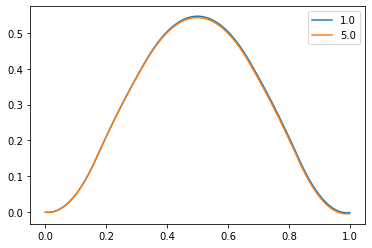

In [92]:
validity_fn = lambda x : x['MaxJump']<0.4 # example
PS = ProcessPAFI('dumps/raw_data_output_2.csv', validity_fn=validity_fn)

PS.integrate(remesh=100)
for i_data in PS.integrated_data:
    
    plt.plot(i_data['ReactionCoordinate'],-i_data['aveF_int'],label=i_data['Temperature'])
plt.legend()

In [ ]:
"""
VERY rough Python code to plot PAFI results

(c) 2021 Tom Swinburne

raw_ensemble_output has 1 + 4*nWorker colums:

Column 0 : Number of workers with max_jump < user threshold at run time
-> nWorker+1 : av(dF), the gradient
-> 2*nWorker+1 : std(dF), the *worker* variance, *not* ensemble error, should not be zero even in infinite time limit!
-> 3*nWorker+1 : av(Psi) = av(dX).dX_0/|dX_0|^2, the tangent projection
-> 4*nWorker+1 : the maximum per-atom jump following the MD
"""

import glob,io
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d


discretization_error_estimate = 0.015 # estimate in eV, divided by 2



# read in file line-by-line, returning ave and std for data with max displacement <= disp_thresh
def raw_parser(file_name,disp_thresh = 0.4):
    try:
        f = open(file_name,'r')
    except IOError:
        print("raw data file %s not found" % file_name)
        return np.zeros((1,3))

    r_dFave_dFstd = []
    r = 0.0
    for line in f.readlines():
        if line[0] != "#":
            fields = np.loadtxt(io.StringIO(line.strip()))
            n_data = (fields.size-1)//4
            n_valid = (fields[-n_data:] < disp_thresh).sum()
            if n_valid>0:
                r_dFave_dFstd += [[r,fields[1:n_valid+1].mean(),fields[1:n_valid+1].std()/np.sqrt(n_valid)]]
            r += 1.0 # always increment even if n_valid==0
    r_dFave_dFstd = np.r_[r_dFave_dFstd]
    r_dFave_dFstd[:,0]/=r_dFave_dFstd[-1][0] # r : 0 -> 1

    return r_dFave_dFstd

# splined rediscretization
def remesh(data,density = 10):
    spl_data = np.zeros((density*data.shape[0],data.shape[1]))
    r_data = np.linspace(0.,1.,data.shape[0])
    r_spl_data = np.linspace(0.,1.,spl_data.shape[0])
    spl_data[:,0] = r_spl_data#interp1d(r_data, data[:,0],kind='linear')(r_spl_data)
    spl_data[:,1] = interp1d(data[:,0], data[:,1],kind='linear')(spl_data[:,0])
    spl_data[:,2] = interp1d(data[:,0], data[:,2],kind='linear')(spl_data[:,0])
    return spl_data

def integrate(data):
    idata = np.zeros(data.shape)
    idata[:,0] = data[:,0]
    idata[1:,1] = -cumtrapz(data[:,1],data[:,0])
    idata[1:,2] = cumtrapz(data[:,2],data[:,0]) +  discretization_error_estimate
    run_min =  np.minimum.accumulate(idata[:,1])
    run_min_shift =  np.minimum.accumulate(np.append(idata[1:,1],idata[-1][1]))
    if (run_min == run_min_shift).sum()>0:
        idata = idata[run_min == run_min_shift,:]
    idata[:,1]-=idata[0][1]
    return idata, idata[:,1].max(), idata[0][2] + idata[idata[:,1].argmax()][2]



# file list- here we take epoch 5
fl = glob.glob("50/dumps/raw*");
print(fl)
# temperatures
T = np.r_[[int(f.split("_")[-2][:-1]) for f in fl]];


fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=144,sharey=True);

bar = []
for ii,i_f in enumerate(T.argsort()):
    _bar = [T[i_f]]
    r_dFave_dFstd = raw_parser(fl[i_f])
    r_Fave_Fstd,barrier,error = integrate(r_dFave_dFstd)

    _bar += [barrier]+[error]
    r_dFave_dFstd_remesh = remesh(r_dFave_dFstd)
    r_Fave_Fstd_remesh,barrier,error = integrate(r_dFave_dFstd_remesh)
    _bar += [barrier]+[error]

    axs[0].plot(r_Fave_Fstd[:,0],
                r_Fave_Fstd[:,1],
                'C%d%s' % (ii,'o--'),label='%dK' % T[i_f])

    axs[0].fill_between(r_Fave_Fstd[:,0],
            r_Fave_Fstd[:,1]-r_Fave_Fstd[:,2],
            r_Fave_Fstd[:,1]+r_Fave_Fstd[:,2],
            facecolor='0.8')

    axs[0].plot(r_Fave_Fstd_remesh[:,0],
                r_Fave_Fstd_remesh[:,1],
                'C%d%s' % (ii,'-'),label='%dK (Splined)' % T[i_f])

    axs[0].fill_between(r_Fave_Fstd_remesh[:,0],
            r_Fave_Fstd_remesh[:,1]-r_Fave_Fstd_remesh[:,2],
            r_Fave_Fstd_remesh[:,1]+r_Fave_Fstd_remesh[:,2],
            facecolor='0.8')

    bar += [_bar]
bar = np.r_[bar]
print(bar.shape)

p = np.polyfit(bar[:3,0],bar[:3,1],1)

kb = 8.617e-5

axs[1].plot(bar[:,0],bar[:,1],'o-',label='Raw Data')
axs[1].plot(bar[:,0],bar[:,3],'o--',label='Splined Data')

axs[1].plot(bar[:,0],p[1]+p[0]*bar[:,0],'k--',label=r'$\Delta U_0=%2.3geV,\Delta S_0=%2.3g{\rm k_B}$' % (p[1],-p[0]/kb))
axs[1].fill_between(bar[:,0],bar[:,1]-bar[:,2],bar[:,1]+bar[:,2],facecolor='0.8')
axs[1].fill_between(bar[:,0],bar[:,3]-bar[:,4],bar[:,3]+bar[:,4],facecolor='0.8')


axs[1].set_ylim(ymin=-discretization_error_estimate)
axs[0].legend(fontsize=7)
axs[1].legend(fontsize=7)

axs[0].set_xlabel("Reaction Coordinate")
axs[1].set_xlabel("Temperature [K]")

axs[0].set_ylabel("Free energy barrier [eV]")

plt.subplots_adjust(wspace=0)
plt.savefig("PAFI_fig.pdf")

array([False, False,  True])

# Load in the raw PAFI `.csv` output and display the first few rows

# Integrate ensemble average data

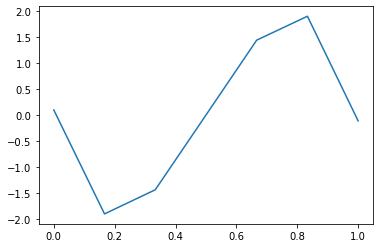

In [16]:
PS.integrate_force()

In [243]:
average_data = ensemble_average(data)
average_data.head()

,Lambda,ReactionCoordinate,Temperature,MaxDev,MaxJump,MinEnergy,Valid,aveF,avePsi,dXTangent,...,MaxJump_std,MinEnergy_std,Valid_std,aveF_std,avePsi_std,dXTangent_std,f_dV_0_std,postT_std,preT_std,stdF_std
0,0.0,0.0,1.0,0.016852,0.017947,-5656.91,1.0,0.099862,1.000000,4.256210e-15,...,0.000124,0.0,0.0,0.012025,0.000000,2.805900e-16,0.002119,0.003545,0.018092,0.000036
1,0.0,0.5,1.0,0.035097,0.040746,-5656.32,1.0,-0.004150,0.977995,1.359590e-15,...,0.000006,0.0,0.0,0.000989,0.001420,2.781600e-16,0.000823,0.004040,0.014818,0.000002
2,0.2,0.0,1.0,0.017689,0.018097,-5656.91,1.0,0.121596,1.000000,4.965565e-15,...,0.000045,0.0,0.0,0.002386,0.000000,2.079925e-15,0.001073,0.004670,0.004791,0.000029
3,0.2,0.5,1.0,0.037481,0.040975,-5656.32,1.0,-0.003651,0.976070,3.533065e-15,...,0.000036,0.0,0.0,0.004196,0.005084,1.745955e-15,0.002546,0.017310,0.016783,0.000016
4,0.4,0.0,1.0,0.016437,0.018039,-5656.91,1.0,0.113721,1.000000,7.972915e-15,...,0.000088,0.0,0.0,0.002368,0.000000,3.458385e-15,0.001040,0.003985,0.002219,0.000040


# Thermodynamic Integration

In [251]:
tdv = []
r_a = average_data['ReactionCoordinate']
for r in set(r_a):
    lam = average_data[r_a==r]['Lambda']    
    dV = average_data[r_a==r]['f_dV_0']
    tdv += [simps(dV,lam)]

print("Energy Difference: ",tdv[1]-tdv[0])


Energy Difference:  0.028876333333333337
